In [1]:
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm 
from sklearn import metrics
from PIL import Image
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

In [2]:
img_type = "png"
batch_size = 8
num_epochs = 10
learning_rate = 1e-03
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
def getImages(path):
    images = []
    cwd = os.getcwd()
    print(os.listdir(cwd))
    for _class in os.listdir(cwd + "\\" + path):
        img_dir = path + "\\" + _class
        for img in os.listdir(img_dir):
            img_path = img_dir + "\\" + img
            images.append([img_path, img_type, int(_class)])

    return pd.DataFrame(images, columns=["path", "type", "class"])

train_images = getImages("dataset\\mnist_png\\training")
test_images = getImages("dataset\\mnist_png\\testing")

train_images

['.git', '.ipynb_checkpoints', '.venv', 'calculator.ipynb', 'dataset', 'mnist_train.ipynb', 'pyproject.toml', 'uv.lock']
['.git', '.ipynb_checkpoints', '.venv', 'calculator.ipynb', 'dataset', 'mnist_train.ipynb', 'pyproject.toml', 'uv.lock']


,path,type,class
0,dataset\mnist_png\training\0\1.png,png,0
1,dataset\mnist_png\training\0\108.png,png,0
2,dataset\mnist_png\training\0\114.png,png,0
3,dataset\mnist_png\training\0\118.png,png,0
4,dataset\mnist_png\training\0\119.png,png,0
...,...,...,...
695,dataset\mnist_png\training\9\621.png,png,9
696,dataset\mnist_png\training\9\626.png,png,9
697,dataset\mnist_png\training\9\631.png,png,9
698,dataset\mnist_png\training\9\80.png,png,9


In [14]:
class Img(Dataset):
    def __init__(self, img_df):
        self.img_df = img_df

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        image = Image.open(img_path)
        image_tesor = TF.to_tensor(image)
        
        label = self.img_df['class'].iloc[idx]
        
        return image_tesor, label

train_img = Img(img_df = train_images)
test_img = Img(img_df = test_images)

train_loader = DataLoader(dataset=train_img, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_img, batch_size=batch_size, shuffle=True)

In [15]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, (2,2))
        x = self.conv2(x)
        x = F.max_pool2d(x, (2,2))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

model = LeNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
def predictDataset(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    
    return actual, prediction

actual, prediction = predictDataset(train_loader, model)
actual, prediction

(array([5., 8., 9., 1., 9., 4., 5., 8., 6., 4., 3., 1., 4., 1., 1., 9., 4.,
        1., 2., 4., 4., 4., 6., 6., 9., 5., 5., 1., 6., 7., 7., 3., 4., 7.,
        1., 8., 6., 7., 8., 0., 9., 2., 3., 3., 4., 5., 9., 4., 3., 1., 7.,
        6., 8., 2., 1., 9., 7., 7., 2., 9., 8., 7., 6., 8., 2., 7., 2., 1.,
        8., 0., 7., 5., 9., 2., 7., 9., 5., 3., 2., 5., 1., 6., 1., 1., 2.,
        1., 0., 6., 8., 7., 3., 0., 8., 3., 7., 4., 0., 7., 9., 7., 4., 4.,
        2., 0., 6., 3., 9., 2., 6., 2., 1., 9., 7., 3., 6., 7., 0., 0., 5.,
        7., 8., 3., 3., 4., 3., 9., 2., 1., 2., 7., 8., 3., 3., 4., 6., 6.,
        2., 6., 3., 2., 6., 5., 8., 9., 8., 2., 3., 6., 1., 1., 6., 8., 3.,
        5., 3., 7., 7., 0., 6., 1., 3., 9., 5., 5., 6., 3., 7., 4., 3., 8.,
        1., 6., 9., 1., 4., 5., 9., 0., 1., 0., 1., 9., 2., 8., 3., 9., 4.,
        9., 0., 8., 3., 4., 2., 3., 4., 3., 1., 6., 7., 4., 0., 0., 9., 5.,
        3., 0., 8., 4., 1., 5., 7., 2., 8., 1., 3., 9., 5., 9., 8., 6., 1.,
        5., 

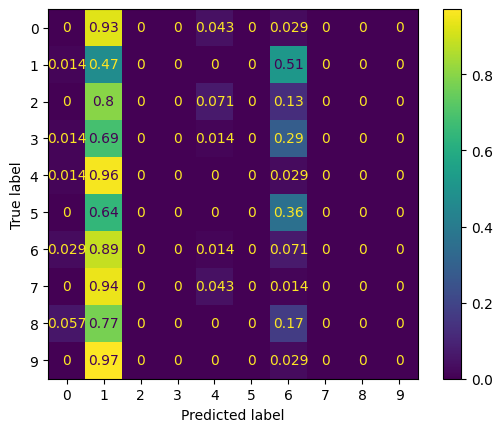

In [17]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.show()
    
    if savefig:
        plt.savefig('confusion_matrix.png')
        
drawConfusionMatrix(actual, prediction, normalize=True)

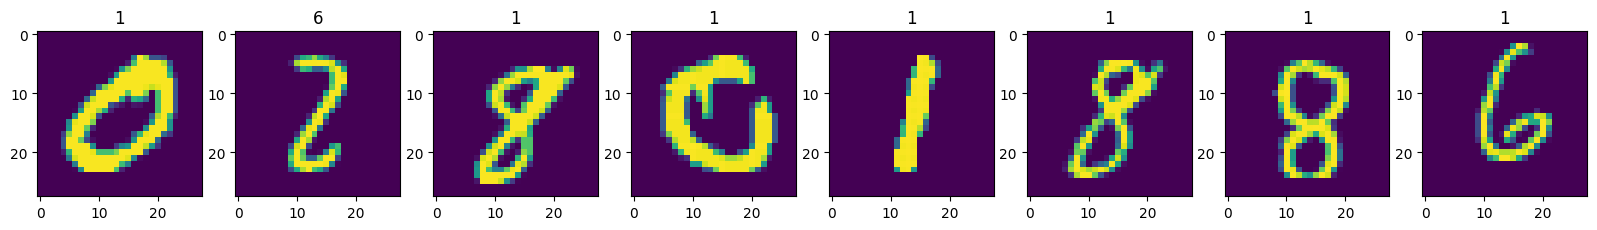

In [18]:
def displayImgs(imgs, labels, classes, n, save=False):
    if n > 32:
        n = 32
    fig = plt.figure(figsize=(20,11))
    for i, tensor in enumerate(imgs[:n]):
        img = torch.zeros(28, 28)
        img[:,:] = tensor  
        fig.add_subplot(4, 8, i + 1).title.set_text(classes[labels[i]])
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        
        _, model_pred = x_.max(1)
        
        displayImgs(x, model_pred, classes=classes, n=batch_size)

        break

In [19]:
def evaluateTorch(loader, model):
    actuals = []
    predictions = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, model_pred = scores.max(1)
            
            actuals.append(y)
            predictions.append(model_pred)
            
    actuals = torch.cat(actuals)
    predictions = torch.cat(predictions)

    oa = (actuals == predictions).sum() / len(actuals)    
    model.train()

    return oa.item()

Epoch[0/9]: 100%|██████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 73.61it/s]


loss:  0.14341725409030914
acc:  0.7666667103767395


Epoch[1/9]: 100%|█████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 108.19it/s]


loss:  0.2971840500831604
acc:  0.8566666841506958


Epoch[2/9]: 100%|█████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 111.44it/s]


loss:  0.04391099885106087
acc:  0.8700000047683716


Epoch[3/9]: 100%|██████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 90.47it/s]


loss:  0.012285742908716202
acc:  0.9000000357627869


Epoch[4/9]: 100%|█████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 110.01it/s]


loss:  0.044251203536987305
acc:  0.8733333349227905


Epoch[5/9]: 100%|█████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 106.80it/s]


loss:  0.003384117502719164
acc:  0.8866667151451111


Epoch[6/9]: 100%|█████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 103.27it/s]


loss:  0.006948654539883137
acc:  0.9100000262260437


Epoch[7/9]: 100%|█████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 106.77it/s]


loss:  0.0009049555519595742
acc:  0.9133333563804626


Epoch[8/9]: 100%|██████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 93.66it/s]


loss:  0.013602065853774548
acc:  0.9133333563804626


Epoch[9/9]: 100%|█████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 111.89it/s]


loss:  0.008061356842517853
acc:  0.9200000166893005


Text(0.5, 1.0, 'Overal accuracy')

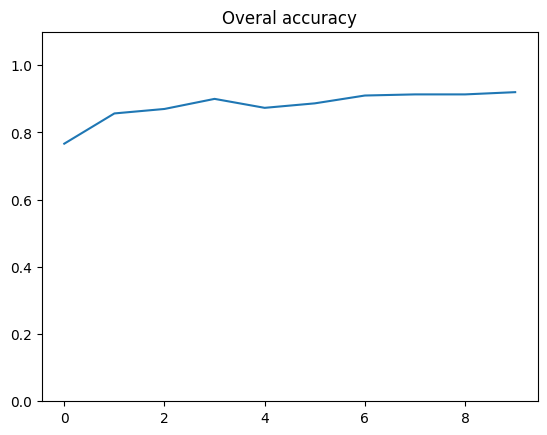

In [20]:
accuracy = []
epochs = []
for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        predictions = torch.argmax(scores, dim=1)
               
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")
        
        batch_loss = np.append(batch_loss, loss.item())

    accuracy.append(evaluateTorch(test_loader, model))
    epochs.append(epoch)

    print("loss: ", batch_loss[-1])
    print("acc: ", accuracy[-1])

plt.plot(epochs, accuracy, label='accuracy')
plt.ylim(0, 1.1)
plt.title("Overal accuracy")

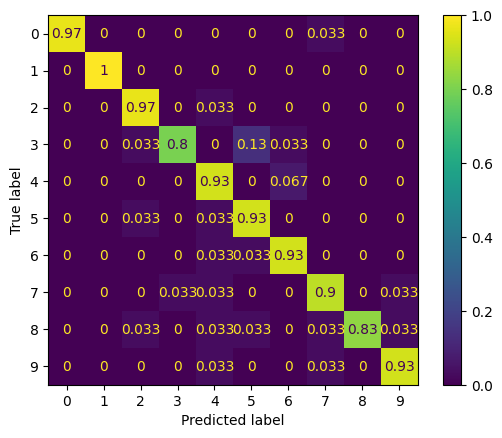

In [21]:
actual, prediction = predictDataset(test_loader, model)

drawConfusionMatrix(actual, prediction, normalize=True)

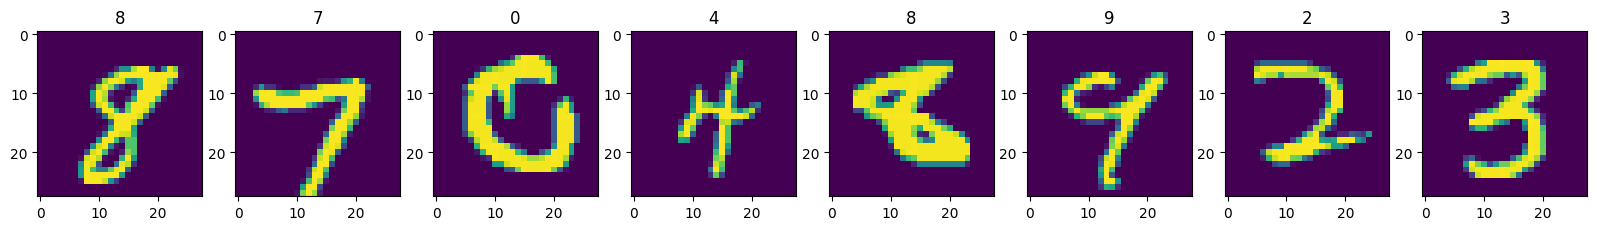

In [22]:
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        
        _, model_pred = x_.max(1)
        
        displayImgs(x, model_pred, classes=classes, n=batch_size)

        break